In [109]:
import re
import mmcv
import json
import torch
import shutil
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from PIL import Image

In [136]:
chimp = pd.read_excel(open('/home/dl18206/Downloads/Chimp & See master chimpanzee video list 2015-2018_OB_analysis.xlsx', 'rb'),
              sheet_name="Otto's Analysis (Plain Text)")

In [137]:
core_videos = glob('../acp/videos/core/**/*.mp4', recursive=True)
core_videos = [x.split('/')[-1].split('.')[0] for x in core_videos]
df = chimp[chimp['ID'].isin(core_videos)]
df['single_ape'] = df.Tags.apply(lambda x: '1_chimp' in x)

<ipython-input-137-549ee0df9a75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['single_ape'] = df.Tags.apply(lambda x: '1_chimp' in x)


In [138]:
df.head()

,ID,Tags,Unnamed: 2,single_ape
1,ACP000002l,chimp 1_chimp early_morning quietwood juvenile...,QW1,True
2,ACP00000ga,chimp 1_chimp qwmale25 quietwood,QW1,True
6,ACP00000ep,chimp qwfam09b 2_chimp qwfam09a quietwood juve...,QW1,False
7,ACP00000g6,chimp needcid 1_chimp quietwood juvenile,QW1,True
8,ACP00000ma,chimp male 1_chimp quietwood qwmale23,QW1,True


**Get videos with only 1 ape in annotations**

In [139]:
annotations = glob('/home/dl18206/Desktop/phd/code/personal/pan-africa-annotation/ape-tracking/annotations/**/*.json', recursive=True)

In [114]:
videos, apes = [], []

for annotation in tqdm(annotations):
    with open(annotation, 'rb') as handle:
        data = json.load(handle)
        
    video = data['video']
    ape_ids = []
    
    for a in data['annotations']:    
        for i in a['detections']:
            ape_ids.append(i['ape_id'])
    if ape_ids == []:
        ids = 0
    else:
        ids = max(ape_ids) + 1
    
    videos.append(video)
    apes.append(ids)

100%|██████████| 5045/5045 [00:11<00:00, 425.71it/s]


In [121]:
a_df = pd.DataFrame([videos, apes]).transpose()

In [122]:
a_df = pd.DataFrame([videos, apes]).transpose()
joined_df = df.join(a_df.set_index(0), on='ID', how='inner')
# joined_df = joined_df[(joined_df.single_ape==True)]

In [141]:
chimp

,ID,Tags,Unnamed: 2
0,ACP000002j,chimp camera_reaction 3_chimp infant juvenile ...,QW1
1,ACP000002l,chimp 1_chimp early_morning quietwood juvenile...,QW1
2,ACP00000ga,chimp 1_chimp qwmale25 quietwood,QW1
3,ACP00000gd,chimp 1_chimp qwmale25 quietwood,QW1
4,ACP00000gf,chimp 1_chimp qwmale25 quietwood,QW1
...,...,...,...
14788,ACP000d2wi,vocalization needcid gsinf01 chimp gaia juveni...,GS16
14789,ACP000d2pf,chimp yoana gsinf31 infant adult camera_reacti...,GS16
14790,ACP000d2pg,gsinf31 yoana dailyzoo carrying_young chimp ca...,GS16
14791,ACP000d2ph,funny yoana gsinf31 juvenile camera_reaction g...,GS16


In [165]:
joined_df[(joined_df.single_ape==True) & (joined_df[1]!=0) & (joined_df[1]<4)].to_excel('tracklet_analysis.xlsx')

In [162]:
chimp.join(joined_df.set_index('ID'), on='ID', how='outer', lsuffix='left', rsuffix='right')

,ID,Tagsleft,Unnamed: 2left,Tagsright,Unnamed: 2right,single_ape,1
0,ACP000002j,chimp camera_reaction 3_chimp infant juvenile ...,QW1,NaN,NaN,NaN,NaN
1,ACP000002l,chimp 1_chimp early_morning quietwood juvenile...,QW1,chimp 1_chimp early_morning quietwood juvenile...,QW1,True,1
2,ACP00000ga,chimp 1_chimp qwmale25 quietwood,QW1,chimp 1_chimp qwmale25 quietwood,QW1,True,1
3,ACP00000gd,chimp 1_chimp qwmale25 quietwood,QW1,NaN,NaN,NaN,NaN
4,ACP00000gf,chimp 1_chimp qwmale25 quietwood,QW1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
14788,ACP000d2wi,vocalization needcid gsinf01 chimp gaia juveni...,GS16,NaN,NaN,NaN,NaN
14789,ACP000d2pf,chimp yoana gsinf31 infant adult camera_reacti...,GS16,NaN,NaN,NaN,NaN
14790,ACP000d2pg,gsinf31 yoana dailyzoo carrying_young chimp ca...,GS16,NaN,NaN,NaN,NaN
14791,ACP000d2ph,funny yoana gsinf31 juvenile camera_reaction g...,GS16,NaN,NaN,NaN,NaN


In [42]:
def make_patch(frame, bbox_scaler=0.15):
    
    x_min_lim = 0
    y_min_lim = 0
    
    x_max_lim = 720
    y_max_lim = 404
    
    species = frame['detections'][0]['species']
    site = frame['detections'][0]['site']
    detection_score = sum([x['detection_score'] for x in frame['detections']]) / len(frame['detections'])
    
    per_frame_detections = frame['detections']
    

    x1, y1, x2, y2 = [], [], [], []

    for d in per_frame_detections:
        x1.append(d['bbox'][0])
        y1.append(d['bbox'][1])
        x2.append(d['bbox'][2])
        y2.append(d['bbox'][3])

    xmin, ymin, xmax, ymax = min(x1), min(y1), max(x2), max(y2)
    
    xmin -= bbox_scaler * (xmax - xmin)
    xmax += bbox_scaler * (xmax - xmin)
    ymin -= bbox_scaler * (ymax - ymin)
    ymax += bbox_scaler * (ymax - ymin)
    
    xmin = x_min_lim if (xmin < x_min_lim) else xmin
    ymin = y_min_lim if (ymin < y_min_lim) else ymin
    
    xmax = x_max_lim if (xmax > x_max_lim) else xmax
    ymax = y_max_lim if (ymax > y_max_lim) else ymax
    
    return dict(frame_id=frame['frame_id'],
         detections = [dict(ape_id=0, species=species, site=site, detection_score=detection_score, bbox=[xmin, ymin, xmax, ymax])]
    )

In [43]:
def frame2patch(video_ids, annotations):
    for v in tqdm(video_ids):
        for a in annotations:
            if(a.split('/')[-1].split('.')[0] == v):
                with open(a, 'rb') as handle:
                    data = json.load(handle)

                for i in range(0, len(data['annotations'])):
                    data['annotations'][i] = make_patch(data['annotations'][i])

                with open(a, 'w') as handle:
                    json.dump(data, handle, ensure_ascii=False, indent=4)

In [45]:
frame2patch(joined_df.ID.values, annotations)

100%|██████████| 1966/1966 [00:28<00:00, 69.37it/s]


In [47]:
with open('/home/dl18206/Desktop/phd/code/personal/pan-africa-annotation/ape-tracking/annotations/ACP000d6gx.json', 'rb') as handle:
    test_annotation = json.load(handle)

test_video = mmcv.VideoReader('/home/dl18206/Desktop/phd/data/panaf/acp/videos/core/tracked/ACP000d6gx.mp4')
test_frame = test_video[0]

In [48]:
test_bbox = test_annotation['annotations'][0]['detections'][0]['bbox']
test_bbox

[81.70554122924804, 258.0314346313477, 245.92088848114014, 404]

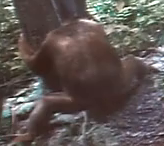

In [49]:
img = Image.fromarray(test_frame)
img.crop(test_bbox)

In [50]:
img.width, img.height

(720, 404)